In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import h5py as h5
from stemutils.io import *
import hyperspy.api as hs

In [3]:
root = Path('/dls/i08/data/2022/mg32587-1/processing/')

In [4]:
root.walk()

[Path('/dls/i08/data/2022/mg32587-1/processing/68025c.nxs'),
 Path('/dls/i08/data/2022/mg32587-1/processing/68049c.nxs'),
 Path('/dls/i08/data/2022/mg32587-1/processing/68060c.nxs'),
 Path('/dls/i08/data/2022/mg32587-1/processing/README.reprocessing'),
 Path('/dls/i08/data/2022/mg32587-1/processing/68028c.nxs')]

In [5]:
fp = root.walk('025c.nxs')[0]

In [6]:
with h5.File(fp) as f:
    #print(f['entry']['scan_shape'])
    fdata = f['entry1']['Counter1']['data'][()]
    pe = f['entry1']['Counter1']['photon_energy'][()]
    sample_x = f['entry1']['Counter1']['sample_x'][()]
    sample_y = f['entry1']['Counter1']['sample_y'][()]
    print(f['entry1']['Counter1'].keys())

<KeysViewHDF5 ['count_time', 'data', 'photon_energy', 'sample_x', 'sample_y', 'scan_type']>


/home/dto55534/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [7]:
cropx = 3
cropy = 2

In [8]:
fdata = fdata[:,cropx:, cropy:]

In [9]:
step_x = np.mean(np.diff(sample_x))
step_y = np.mean(np.diff(sample_y))

In [10]:
fdata.shape

(96, 27, 33)

In [11]:
sample_y.shape

(30,)

In [12]:
fsig = hs.signals.Signal2D(fdata)

/dls_sw/apps/python/anaconda/4.6.14/64/envs/epsic3.7/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


In [13]:
fdata.shape

(96, 27, 33)

In [14]:
th_data = []
thresh_val =0.7
for d in fdata:
    th_data.append(np.where(d< d.max()*thresh_val,1,0))

In [15]:
th_data = np.asarray(th_data)

In [16]:
th_data = th_data

In [17]:
tsig = hs.signals.Signal2D(np.asarray(th_data))

In [18]:
tsig

<Signal2D, title: , dimensions: (96|33, 27)>

<IPython.core.display.Javascript object>


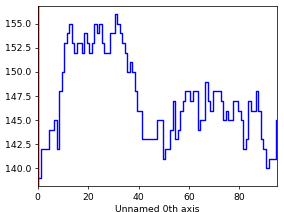

<IPython.core.display.Javascript object>


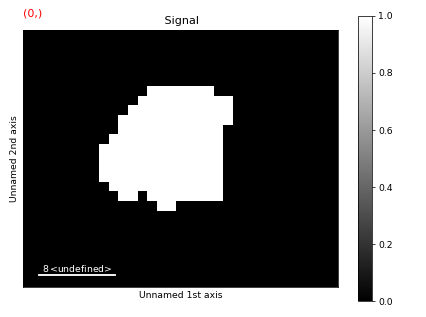

In [19]:
tsig.plot()

<IPython.core.display.Javascript object>


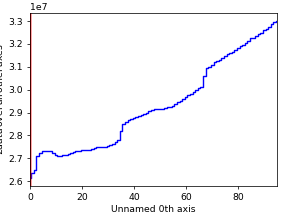

<IPython.core.display.Javascript object>


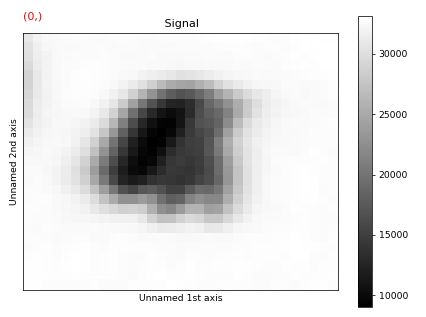

In [20]:
fsig.plot()

In [21]:
from skimage import filters, feature

In [22]:
tdata = th_data[0]

In [23]:
roberts = filters.roberts(tdata.astype('float'))

In [24]:
bin_rob = np.where(roberts != 0, 1, 0)

In [25]:
import matplotlib.pyplot as plt

In [26]:
from scipy.ndimage.measurements import center_of_mass as com

<IPython.core.display.Javascript object>


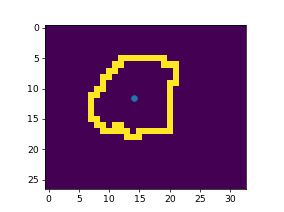

In [27]:
plt.figure()
plt.imshow(bin_rob)
com_bin_rob = com(bin_rob)
plt.scatter(com_bin_rob[1], com_bin_rob[0])

In [28]:
all_rob = np.asarray([np.where(filters.roberts(tdata.astype('float')) != 0, 1,0) for tdata in th_data])
coms = np.asarray([com(rob) for rob in all_rob])

<IPython.core.display.Javascript object>


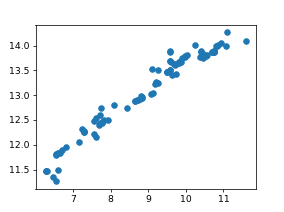

In [29]:
plt.figure()
plt.scatter(coms[:,0], coms[:,1])

In [30]:
pfit = np.polyfit(coms[:,0], coms[:,1], 5)

In [31]:
px = np.linspace(6,12,1000)
py = np.polyval(pfit, px)

In [32]:
pvals = np.concatenate((px[:,None], py[:,None]), axis = 1)

In [33]:
pvals_comp = px +1j*py
coms_comp = coms[:,0] + 1j*coms[:,1]

<IPython.core.display.Javascript object>


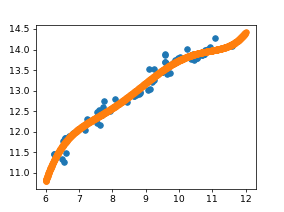

In [34]:
plt.figure()
plt.scatter(coms[:,0], coms[:,1])
plt.scatter(px,py)

In [35]:
reg_coms = []
for com_comp in coms_comp:
    reg_com = pvals_comp[np.argmin(np.abs(pvals_comp - com_comp))]
    reg_coms.append((reg_com.real, reg_com.imag))
reg_coms = np.asarray((reg_coms))

In [36]:
all_rob_sig = hs.signals.Signal2D(all_rob)

<IPython.core.display.Javascript object>


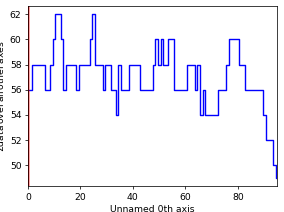

<IPython.core.display.Javascript object>


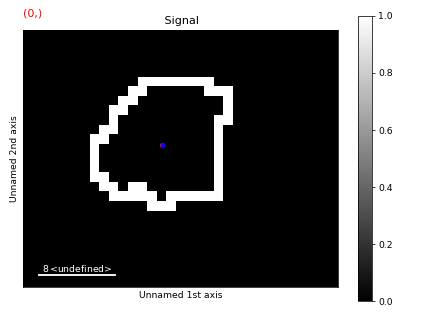

In [37]:
m = hs.plot.markers.point(x = coms[:,1], y = coms[:,0], color='red')
all_rob_sig.add_marker(m)
m2 = hs.plot.markers.point(x = reg_coms[:,1], y = reg_coms[:,0], color='blue')
all_rob_sig.add_marker(m2)

In [38]:
ffsig = hs.signals.Signal2D(fdata)

<IPython.core.display.Javascript object>


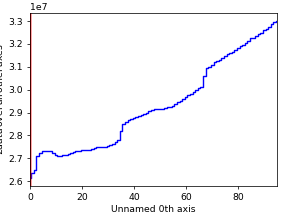

<IPython.core.display.Javascript object>


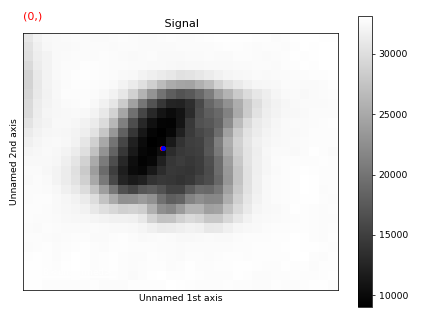

In [39]:
m3 = hs.plot.markers.point(x = coms[:,1], y = coms[:,0], color='red')
ffsig.add_marker(m3)
m4 = hs.plot.markers.point(x = reg_coms[:,1], y = reg_coms[:,0], color='blue')
ffsig.add_marker(m4)

In [40]:
from scipy.ndimage import shift

In [41]:
reg_shift = reg_coms - reg_coms[0]

In [42]:
reg_data = []
for ind, shift_val in enumerate(reg_shift):
    reg_data.append(shift(fdata[ind], -shift_val))

In [43]:
reg_sig = hs.signals.Signal2D(reg_data)

<IPython.core.display.Javascript object>


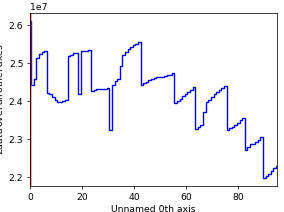

<IPython.core.display.Javascript object>


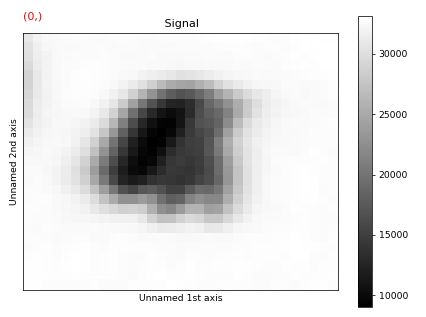

In [44]:
reg_sig.plot()

In [45]:
max_shifts = reg_shift[np.argmax(np.abs(reg_shift), axis = 0)[0]][0], reg_shift[np.argmax(np.abs(reg_shift), axis = 0)[1]][1]

In [46]:
max_crop = np.ceil(np.abs(max_shifts))*np.sign(max_shifts).astype('int')

In [47]:
-int(max_crop[1])

3

In [48]:
final_reg_sig = hs.signals.Signal2D(reg_sig.data[:,-int(max_crop[0]):, -int(max_crop[1]):])

In [49]:
final_reg_data = final_reg_sig.data

<IPython.core.display.Javascript object>


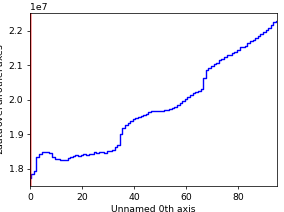

<IPython.core.display.Javascript object>


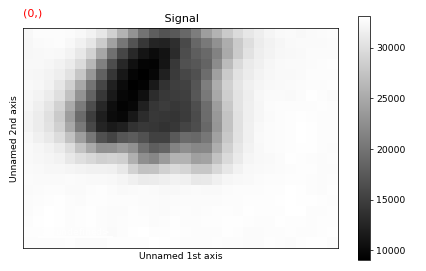

In [50]:
final_reg_sig.plot()

In [51]:
final_reg_data.shape

(96, 21, 30)

In [52]:
sigT_data = final_reg_data.transpose((1,2,0))

In [53]:
sigT_data.shape

(21, 30, 96)

In [54]:
dict0 = {'axis':pe, 'units': 'eV'}
dict1 = {'axis':np.arange(0, sigT_data.shape[0] * step_x, step_x), 'units': 'um'}
dict2 = {'axis':np.arange(0, sigT_data.shape[1]*step_y, step_y), 'units': 'um'}

In [55]:
dict2['axis'].shape

(30,)

In [56]:
dict1['axis'].shape

(21,)

In [57]:
sigT = hs.signals.Signal1D(sigT_data,axes = [dict2, dict1, dict0])

In [58]:
sigT.axes_manager

Navigation axis name,size,index,offset,scale,units
,21,0,non-uniform axis,non-uniform axis,um
,30,0,non-uniform axis,non-uniform axis,um
Signal axis name,size,,offset,scale,units
,96,,non-uniform axis,non-uniform axis,eV


<IPython.core.display.Javascript object>


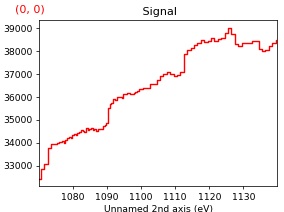

In [59]:
sigT.plot()

In [60]:
sigT2 = hs.signals.Signal1D(sigT_data)

<IPython.core.display.Javascript object>


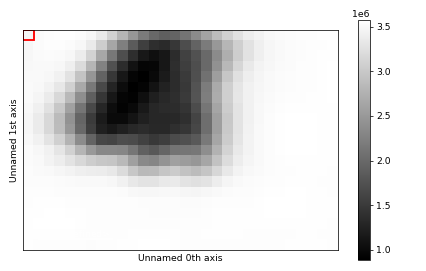

<IPython.core.display.Javascript object>


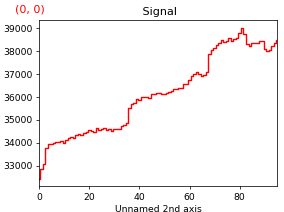

In [61]:
sigT2.plot()

In [62]:
sum_ints = np.sum(final_reg_data, axis = (0))

In [63]:
sum_ints.shape

(21, 30)

In [64]:
bkg_thresh = 0.99

In [65]:
bkg_mask = np.where(sum_ints>np.max(sum_ints)*bkg_thresh,1,0)
mask_loc = np.where(sum_ints>np.max(sum_ints)*bkg_thresh+0.2)

<IPython.core.display.Javascript object>


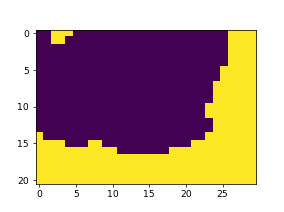

In [66]:
plt.figure()
plt.imshow(bkg_mask)

In [67]:
mask_coords = np.asarray(mask_loc).T

In [68]:
all_bkg = []
for mc in mask_coords:
    all_bkg.append(sigT.data[mc[0], mc[1],:])
all_bkg = np.asarray(all_bkg)

In [69]:
mean_bkg_profile = np.mean(all_bkg, axis = 0)

<IPython.core.display.Javascript object>


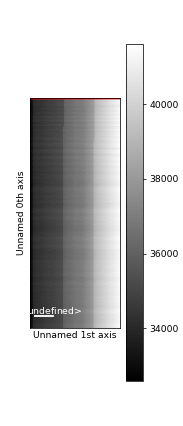

/home/dto55534/.local/lib/python3.7/site-packages/hyperspy/drawing/utils.py:159: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**kwargs)


<IPython.core.display.Javascript object>


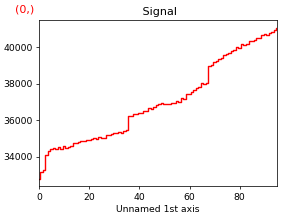

In [70]:
hs.signals.Signal1D(all_bkg).plot()

<IPython.core.display.Javascript object>


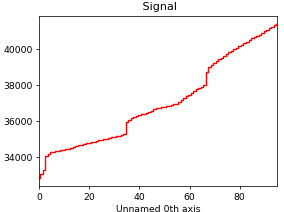

In [71]:
hs.signals.Signal1D(mean_bkg_profile).plot()

In [72]:
abs_sig = hs.signals.Signal1D(1-(sigT.data / mean_bkg_profile[None,None,:]))

<IPython.core.display.Javascript object>


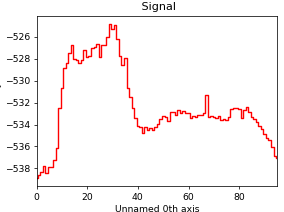

In [73]:
hs.signals.Signal1D(1-(sigT.data / mean_bkg_profile[None,None,:]).sum(axis = (0,1))).plot()

<IPython.core.display.Javascript object>


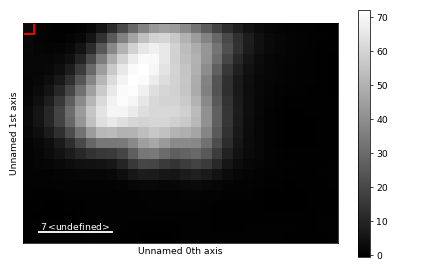

<IPython.core.display.Javascript object>


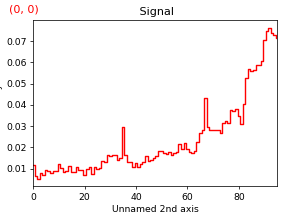

In [74]:
abs_sig.plot()

<IPython.core.display.Javascript object>


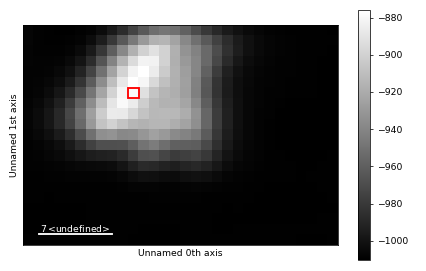

<IPython.core.display.Javascript object>


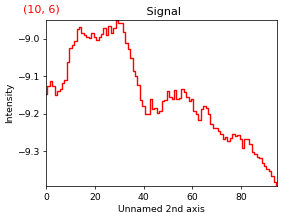

In [86]:
hs.signals.Signal1D(-np.log(sigT.data)).plot()

In [87]:
abs_sig_en = hs.signals.Signal1D(abs_sig.data,axes = [dict2, dict1, dict0])

<IPython.core.display.Javascript object>


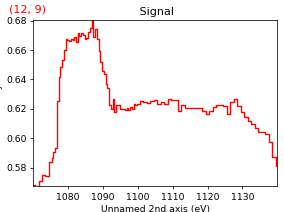

In [88]:
abs_sig_en.plot()